# Appling machine learning to audio analysis

## Trainning Code - Using cut audios of setA. No moving windows.

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [63]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/107909f9526b4563b938925ffe0c38e7



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [21]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    audio =
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    mfccs_std = np.std(mfccs.T,axis=0)
    mfccs_out = np.hstack((mfccs_processed, mfccs_std))
     
    return mfccs_out

In [22]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [23]:
from os.path import exists

In [24]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 #Conta os ficheiros que tiveram os MFCCs analizados
i = 0 # numero total de ficheiros

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    #print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            
            sounds.append([data, class_label])
            cont += 1
        else:
            print(file_name)
            
print(i, cont)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1750
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1751
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1222
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1122
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1888
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224

801 800


In [25]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain_std_mfccs40.pkl') 

## Model building and training

### Load MFFCs from saved files

In [26]:
fileMFCCs = '../MFCCs/cutA_toTrain_std_mfccs40.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [27]:
keras.backend.clear_session()
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
print(X)
y = np.array(featuresdf.class_label.tolist())


# Encode the classification labels
le = LabelEncoder()

yy = to_categorical(le.fit_transform(y))

[[-328.07162    138.91454      7.4351997 ...    4.6279297    4.0143585
     1.9111754]
 [-336.12396    131.63614      9.702477  ...    1.187016     1.401478
     1.9111346]
 [-331.10678    136.21701     10.334246  ...    3.1113284    1.9073809
     2.588381 ]
 ...
 [-576.6643     132.03662     73.05437   ...    1.9755619    1.23038
     2.0154724]
 [-612.7163     152.76172     69.798096  ...    3.773394     3.2577863
     2.3133342]
 [-538.7162     103.57261     67.25909   ...    1.9336804    3.9143596
     2.7809107]]


### Trainning and test sets

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [47]:

num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(80,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (640, 512)                41472     
_________________________________________________________________
activation_4 (Activation)    (640, 512)                0         
_________________________________________________________________
dropout_3 (Dropout)          (640, 512)                0         
_________________________________________________________________
dense_5 (Dense)              (640, 512)                262656    
_________________________________________________________________
activation_5 (Activation)    (640, 512)                0         
_________________________________________________________________
dropout_4 (Dropout)          (640, 512)                0         
_________________________________________________________________
dense_6 (Dense)              (640, 512)               

### Model Trainning

In [48]:
num_epochs = 700
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_std_mffcs40_Hist_700.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Epoch 1/700
20/20 [==============================] - 2s 8ms/step - loss: 24.8049 - accuracy: 0.3844 - val_loss: 4.9441 - val_accuracy: 0.6250
Epoch 2/700
20/20 [==============================] - 0s 8ms/step - loss: 11.9709 - accuracy: 0.4578 - val_loss: 2.0586 - val_accuracy: 0.4250
Epoch 3/700
20/20 [==============================] - 0s 8ms/step - loss: 7.0232 - accuracy: 0.4922 - val_loss: 1.4667 - val_accuracy: 0.4375
Epoch 4/700
20/20 [==============================] - 0s 6ms/step - loss: 5.7226 - accuracy: 0.4672 - val_loss: 0.9540 - val_accuracy: 0.5750
Epoch 5/700
20/20 [==============================] - 0s 6ms/step - loss: 3.7590 - accuracy: 0.5016 - val_loss: 0.8018 - val_accuracy: 0.6812
Epoch 6/700
20/20 [==============================] - 0s 6ms/step - loss: 2.9323 - accuracy: 0.5266 - val_loss: 0.7067 - val_accuracy: 0.6938
Epoch 7/700
20/20 [==============================] - 0s 6ms/step - loss: 2.3577 - accuracy: 0.4938 - val_loss: 0.7583 - val_accuracy: 0.6875
Epoch 8/700

Epoch 59/700
20/20 [==============================] - 0s 6ms/step - loss: 0.5993 - accuracy: 0.7141 - val_loss: 0.5883 - val_accuracy: 0.7563
Epoch 60/700
20/20 [==============================] - 0s 6ms/step - loss: 0.5663 - accuracy: 0.7031 - val_loss: 0.5765 - val_accuracy: 0.7625
Epoch 61/700
20/20 [==============================] - 0s 5ms/step - loss: 0.5808 - accuracy: 0.7016 - val_loss: 0.5597 - val_accuracy: 0.7500
Epoch 62/700
20/20 [==============================] - 0s 5ms/step - loss: 0.5817 - accuracy: 0.7016 - val_loss: 0.5657 - val_accuracy: 0.7750
Epoch 63/700
20/20 [==============================] - 0s 5ms/step - loss: 0.5920 - accuracy: 0.6984 - val_loss: 0.5495 - val_accuracy: 0.7625
Epoch 64/700
20/20 [==============================] - 0s 6ms/step - loss: 0.5675 - accuracy: 0.7219 - val_loss: 0.5622 - val_accuracy: 0.7563
Epoch 65/700
20/20 [==============================] - 0s 6ms/step - loss: 0.5536 - accuracy: 0.7109 - val_loss: 0.5585 - val_accuracy: 0.7500
Epoch 

20/20 [==============================] - 0s 6ms/step - loss: 0.4533 - accuracy: 0.7594 - val_loss: 0.5148 - val_accuracy: 0.8188
Epoch 117/700
20/20 [==============================] - 0s 7ms/step - loss: 0.4027 - accuracy: 0.8000 - val_loss: 0.4913 - val_accuracy: 0.8188
Epoch 118/700
20/20 [==============================] - 0s 9ms/step - loss: 0.3704 - accuracy: 0.8328 - val_loss: 0.5169 - val_accuracy: 0.8000
Epoch 119/700
20/20 [==============================] - 0s 7ms/step - loss: 0.3882 - accuracy: 0.8234 - val_loss: 0.5120 - val_accuracy: 0.8188
Epoch 120/700
20/20 [==============================] - 0s 6ms/step - loss: 0.3983 - accuracy: 0.8047 - val_loss: 0.5428 - val_accuracy: 0.8000
Epoch 121/700
20/20 [==============================] - 0s 6ms/step - loss: 0.3973 - accuracy: 0.8062 - val_loss: 0.5058 - val_accuracy: 0.8188
Epoch 122/700
20/20 [==============================] - 0s 6ms/step - loss: 0.3862 - accuracy: 0.8109 - val_loss: 0.5392 - val_accuracy: 0.8000
Epoch 123/700

20/20 [==============================] - 0s 6ms/step - loss: 0.3059 - accuracy: 0.8625 - val_loss: 0.5927 - val_accuracy: 0.8313
Epoch 174/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2751 - accuracy: 0.8656 - val_loss: 0.5938 - val_accuracy: 0.8313
Epoch 175/700
20/20 [==============================] - 0s 7ms/step - loss: 0.2879 - accuracy: 0.8687 - val_loss: 0.6392 - val_accuracy: 0.7937
Epoch 176/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2965 - accuracy: 0.8625 - val_loss: 0.5922 - val_accuracy: 0.8438
Epoch 177/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2720 - accuracy: 0.8891 - val_loss: 0.6004 - val_accuracy: 0.8250
Epoch 178/700
20/20 [==============================] - 0s 7ms/step - loss: 0.2809 - accuracy: 0.8719 - val_loss: 0.6037 - val_accuracy: 0.8313
Epoch 179/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2706 - accuracy: 0.8766 - val_loss: 0.6213 - val_accuracy: 0.8750
Epoch 180/700

20/20 [==============================] - 0s 5ms/step - loss: 0.2615 - accuracy: 0.8797 - val_loss: 0.6278 - val_accuracy: 0.8313
Epoch 231/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2430 - accuracy: 0.8875 - val_loss: 0.6512 - val_accuracy: 0.8500
Epoch 232/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2305 - accuracy: 0.9141 - val_loss: 0.5939 - val_accuracy: 0.8500
Epoch 233/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2209 - accuracy: 0.9062 - val_loss: 0.6527 - val_accuracy: 0.8250
Epoch 234/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2085 - accuracy: 0.8938 - val_loss: 0.6460 - val_accuracy: 0.8313
Epoch 235/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2017 - accuracy: 0.9234 - val_loss: 0.7266 - val_accuracy: 0.8188
Epoch 236/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2478 - accuracy: 0.9062 - val_loss: 0.6898 - val_accuracy: 0.8250
Epoch 237/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9187 - val_loss: 0.7421 - val_accuracy: 0.8438
Epoch 288/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1888 - accuracy: 0.9156 - val_loss: 0.7102 - val_accuracy: 0.8500
Epoch 289/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.9094 - val_loss: 0.7279 - val_accuracy: 0.8313
Epoch 290/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9172 - val_loss: 0.8045 - val_accuracy: 0.8313
Epoch 291/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2311 - accuracy: 0.8984 - val_loss: 0.6842 - val_accuracy: 0.8250
Epoch 292/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1820 - accuracy: 0.9250 - val_loss: 0.6999 - val_accuracy: 0.8500
Epoch 293/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1733 - accuracy: 0.9203 - val_loss: 0.7186 - val_accuracy: 0.8438
Epoch 294/700

20/20 [==============================] - 0s 6ms/step - loss: 0.1561 - accuracy: 0.9266 - val_loss: 0.8091 - val_accuracy: 0.8250
Epoch 345/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1505 - accuracy: 0.9391 - val_loss: 0.7221 - val_accuracy: 0.8375
Epoch 346/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1501 - accuracy: 0.9359 - val_loss: 0.8037 - val_accuracy: 0.8250
Epoch 347/700
20/20 [==============================] - 0s 8ms/step - loss: 0.2046 - accuracy: 0.9094 - val_loss: 0.7994 - val_accuracy: 0.7750
Epoch 348/700
20/20 [==============================] - 0s 8ms/step - loss: 0.2141 - accuracy: 0.9047 - val_loss: 0.7974 - val_accuracy: 0.7937
Epoch 349/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1996 - accuracy: 0.9078 - val_loss: 0.6811 - val_accuracy: 0.8500
Epoch 350/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1690 - accuracy: 0.9266 - val_loss: 0.7073 - val_accuracy: 0.8313
Epoch 351/700

20/20 [==============================] - 0s 5ms/step - loss: 0.2169 - accuracy: 0.9016 - val_loss: 0.7509 - val_accuracy: 0.8375
Epoch 402/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9359 - val_loss: 0.9213 - val_accuracy: 0.8062
Epoch 403/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9078 - val_loss: 0.8214 - val_accuracy: 0.8062
Epoch 404/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9094 - val_loss: 0.7430 - val_accuracy: 0.7937
Epoch 405/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2179 - accuracy: 0.9109 - val_loss: 0.7372 - val_accuracy: 0.8125
Epoch 406/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1781 - accuracy: 0.9156 - val_loss: 0.7843 - val_accuracy: 0.8500
Epoch 407/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1945 - accuracy: 0.9234 - val_loss: 0.7526 - val_accuracy: 0.8062
Epoch 408/700

20/20 [==============================] - 0s 5ms/step - loss: 0.1566 - accuracy: 0.9359 - val_loss: 0.8432 - val_accuracy: 0.8313
Epoch 459/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1695 - accuracy: 0.9250 - val_loss: 0.8220 - val_accuracy: 0.8062
Epoch 460/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1853 - accuracy: 0.9141 - val_loss: 0.8352 - val_accuracy: 0.7937
Epoch 461/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1819 - accuracy: 0.9234 - val_loss: 0.7753 - val_accuracy: 0.8313
Epoch 462/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1497 - accuracy: 0.9328 - val_loss: 0.8203 - val_accuracy: 0.8438
Epoch 463/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.9344 - val_loss: 0.7799 - val_accuracy: 0.8188
Epoch 464/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1217 - accuracy: 0.9406 - val_loss: 0.9184 - val_accuracy: 0.8062
Epoch 465/700

20/20 [==============================] - 0s 5ms/step - loss: 0.2302 - accuracy: 0.9078 - val_loss: 0.8938 - val_accuracy: 0.7875
Epoch 516/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2292 - accuracy: 0.9156 - val_loss: 0.7374 - val_accuracy: 0.7875
Epoch 517/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1882 - accuracy: 0.9234 - val_loss: 0.7307 - val_accuracy: 0.7875
Epoch 518/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1787 - accuracy: 0.9234 - val_loss: 0.7427 - val_accuracy: 0.8062
Epoch 519/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9000 - val_loss: 0.7701 - val_accuracy: 0.8062
Epoch 520/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1906 - accuracy: 0.9109 - val_loss: 0.7437 - val_accuracy: 0.8000
Epoch 521/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9250 - val_loss: 0.8092 - val_accuracy: 0.7875
Epoch 522/700

20/20 [==============================] - 0s 5ms/step - loss: 0.1714 - accuracy: 0.9328 - val_loss: 0.9533 - val_accuracy: 0.8062
Epoch 573/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1489 - accuracy: 0.9344 - val_loss: 0.8249 - val_accuracy: 0.8250
Epoch 574/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1684 - accuracy: 0.9312 - val_loss: 0.8216 - val_accuracy: 0.7875
Epoch 575/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1689 - accuracy: 0.9219 - val_loss: 0.9198 - val_accuracy: 0.8000
Epoch 576/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1762 - accuracy: 0.9375 - val_loss: 0.9036 - val_accuracy: 0.8000
Epoch 577/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1749 - accuracy: 0.9172 - val_loss: 0.7394 - val_accuracy: 0.8000
Epoch 578/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2201 - accuracy: 0.9125 - val_loss: 0.9700 - val_accuracy: 0.7563
Epoch 579/700

20/20 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9453 - val_loss: 0.9991 - val_accuracy: 0.7812
Epoch 630/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1977 - accuracy: 0.9250 - val_loss: 1.0751 - val_accuracy: 0.7688
Epoch 631/700
20/20 [==============================] - 0s 7ms/step - loss: 0.1692 - accuracy: 0.9328 - val_loss: 0.7926 - val_accuracy: 0.8250
Epoch 632/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1687 - accuracy: 0.9375 - val_loss: 1.0681 - val_accuracy: 0.7750
Epoch 633/700
20/20 [==============================] - 0s 9ms/step - loss: 0.1491 - accuracy: 0.9422 - val_loss: 0.9082 - val_accuracy: 0.7937
Epoch 634/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1470 - accuracy: 0.9297 - val_loss: 0.9137 - val_accuracy: 0.8188
Epoch 635/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1537 - accuracy: 0.9234 - val_loss: 1.0311 - val_accuracy: 0.8062
Epoch 636/700

20/20 [==============================] - 0s 5ms/step - loss: 0.2328 - accuracy: 0.9078 - val_loss: 1.0668 - val_accuracy: 0.8000
Epoch 687/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2616 - accuracy: 0.8984 - val_loss: 0.8017 - val_accuracy: 0.7750
Epoch 688/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2102 - accuracy: 0.9062 - val_loss: 0.8499 - val_accuracy: 0.7937
Epoch 689/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2390 - accuracy: 0.9078 - val_loss: 0.8891 - val_accuracy: 0.7688
Epoch 690/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1800 - accuracy: 0.9312 - val_loss: 0.9535 - val_accuracy: 0.7937
Epoch 691/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1982 - accuracy: 0.9203 - val_loss: 0.9306 - val_accuracy: 0.8000
Epoch 692/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.9281 - val_loss: 1.2274 - val_accuracy: 0.7688
Epoch 693/700

In [84]:
model.save('../model_save/cut_setA_Train_std_mffcs40_Hist_700/saved_model', save_format='tf')

INFO:tensorflow:Assets written to: ../model_save/cut_setA_Train_std_mffcs40_Hist_700/saved_model/assets


### Confusion Matrix

In [71]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[27, 15,  2],
       [ 9, 20,  1],
       [ 6,  1, 79]])

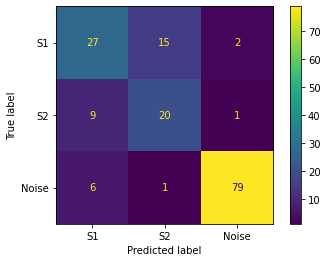

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = ["S1","S2","Noise"] )
disp.plot()
plt.show()

### Plot of model performance

In [85]:
history = pd.read_csv('../model_save/cut_setA_Train_std_mffcs40_Hist_700.log')
history.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.384375,24.804943,0.62500,4.944088
1,1,0.457812,11.970932,0.42500,2.058628
2,2,0.492188,7.023241,0.43750,1.466740
3,3,0.467187,5.722591,0.57500,0.954011
4,4,0.501562,3.759024,0.68125,0.801778


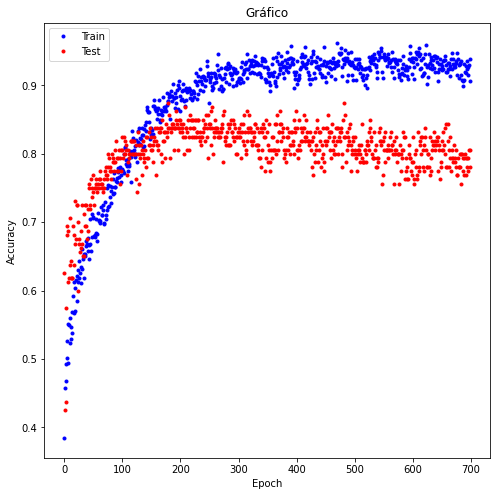

In [88]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)

Plot.plot(xx, yy, "b.", label = 'Train')

yy = np.array(history.val_accuracy.tolist())
Plot.plot(xx, yy, "r.", label = 'Test')

#Plot.axvline(x=Ei, c='red')
#Plot.axhline(y=npy.log(tauN), c='purple')

Plot.title.set_text("Gráfico")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")
Plot.legend()

In [19]:
fig.savefig('../images/performance/700Epoch_std_mfccs40.jpg')

In [20]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/107909f9526b4563b938925ffe0c38e7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [700]                : (0.41093748807907104, 0.8999999761581421)
COMET INFO:     batch_accuracy [1400]         : (0.375, 1.0)
COMET INFO:     batch_loss [1400]             : (0.06605146825313568, 33.84919738769531)
COMET INFO:     epoch_duration [700]          : (0.07741340000006858, 11.505419500000016)
COMET INFO:     loss [700]                    : (0.23136909306049347, 24.342327117919922)
COMET INFO:     val_accuracy [700]            : (0.2562499940395355, 0.875)
COMET INFO:     val_loss [700]                : (0.3516857922077179, 5.794822692871094)
COMET INFO:     validate_batch_accuracy [700] : (0.25, 0.90625)
COMET INFO:     